In [1]:
from utils import *
import rxrx
from openTSNE.sklearn import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from scipy.stats import pearsonr
from sklearn.svm import SVC
import gc
import seaborn
seaborn.set()

# Visualizing Batch Effects

This notebook is mostly repeating the work of dohlee on Kaggle, check out their kernel at [this link](https://www.kaggle.com/apap950419/visualizing-batch-effects-with-t-sne).

Let's begin by loading in the train controls dataframe and filter out cells besides HEPG2, which we will focus on.

In [3]:
train_controls = pd.read_csv(os.path.join(RECURSION_TRAIN_DIR, 'train_controls.csv'))
train_controls['cell_line'] = [v[0] for v in train_controls.id_code.str.split('-')]
train_controls = train_controls[train_controls['cell_line'] == 'HEPG2']
train_controls.head()

,id_code,experiment,plate,well,sirna,well_type,cell_line
0,HEPG2-01_1_B02,HEPG2-01,1,B02,1138,negative_control,HEPG2
1,HEPG2-01_1_C03,HEPG2-01,1,C03,1109,positive_control,HEPG2
2,HEPG2-01_1_C07,HEPG2-01,1,C07,1121,positive_control,HEPG2
3,HEPG2-01_1_C11,HEPG2-01,1,C11,1126,positive_control,HEPG2
4,HEPG2-01_1_C15,HEPG2-01,1,C15,1118,positive_control,HEPG2


In [4]:
positive_control_sirna = train_controls[train_controls.well_type == 'positive_control'].sirna.unique()
negative_control_sirna = train_controls[train_controls.well_type == 'negative_control'].sirna.unique()[0]
print(f'sirna used for positive control: {positive_control_sirna}, sirna used for negative control: {negative_control_sirna}')

sirna used for positive control: [1109 1121 1126 1118 1116 1110 1113 1114 1137 1120 1117 1135 1115 1131
 1125 1127 1123 1108 1122 1132 1124 1134 1128 1130 1136 1133 1112 1129
 1119 1111], sirna used for negative control: 1138


In [5]:
len(positive_control_sirna)

30

In [6]:
images = np.empty((len(train_controls), 2, 6, 512, 512))
experiments = []
for i, row in train_controls.iterrows():
    experiments.append(row.experiment)
    for site in range(2):
        for ch in range(6):
            images[i, site, ch] = read_image(get_image_path(row.experiment, row.plate, row.well, 
                                                         site+1, ch+1, train=True))

In [7]:
images.shape

(872, 2, 6, 512, 512)

In [198]:
experiments = [int(exp[-1:]) -1 for exp in experiments]

In [6]:
len(experiments)

872

In [8]:
per_channel_means = np.mean(images, axis=(1, 3, 4))

In [10]:
per_channel_medians = np.median(images, axis=(1, 3, 4))

In [11]:
gc.collect()

1491

In [12]:
per_channel_variance = np.var(images, axis=(1, 3, 4))

In [13]:
statistics = np.concatenate((per_channel_means, per_channel_medians, per_channel_variance), axis=1)

In [14]:
statistics.shape

(872, 18)

In [15]:
embedding = TSNE().fit_transform(statistics)

/home/kaandonbekci/anaconda3/envs/recursion/lib/python3.6/site-packages/openTSNE/nearest_neighbors.py:184: UserWarning: `pynndescent` has recently changed which distance metrics are supported, and `openTSNE.nearest_neighbors` has not been updated. Please notify the developers of this change.
  "`pynndescent` has recently changed which distance metrics are supported, "
/home/kaandonbekci/anaconda3/envs/recursion/lib/python3.6/site-packages/numba/ir_utils.py:1969: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../home/kaandonbekci/anaconda3/envs/recursion/lib/python3.6/site-packages/pynndescent/pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWa

In [16]:
embedding.shape

(872, 2)

By experiment visualization:

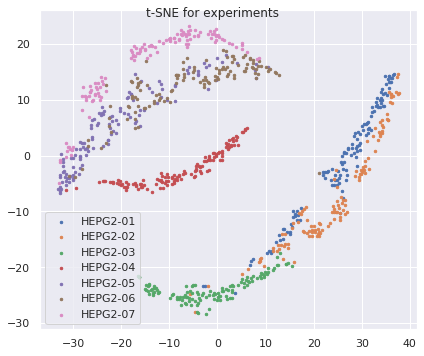

In [20]:
fig = plt.figure(figsize=(6, 5))
for exp in train_controls.experiment.unique():
    mask = (train_controls.experiment.values == exp)
    plt.scatter(embedding[mask, 0], embedding[mask, 1], label=exp, s=6)
plt.suptitle('t-SNE for experiments')
plt.legend()
fig.tight_layout()

In [291]:
kmeans = KMeans(n_clusters=7)

In [292]:
k_means_prediction = kmeans.fit_predict(embedding)

In [293]:
conf = confusion_matrix(k_means_prediction, _experiments)

In [294]:
conf

array([[  0,   0,   0,   0,  20,  75,  57],
       [ 41,  74,  20,   0,   0,   1,   0],
       [  0,   0,   0,  33,  62,   8,  14],
       [ 80,  47,   0,   0,   0,   0,   0],
       [  5,   5, 104,   0,   0,   0,   0],
       [  0,   0,   0,   0,  42,  40,  53],
       [  0,   0,   0,  91,   0,   0,   0]])

In [299]:
conf.argmax(0)

array([3, 1, 4, 6, 2, 0, 0])

In [300]:
true_ordering = np.array([3, 1, 4, 6, 2, 0, 5])

In [301]:
adjusted_kmm_predictions = true_ordering[k_means_prediction[:, None]].flatten()

In [302]:
print(classification_report(_experiments, adjusted_kmm_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       126
           1       0.54      0.59      0.56       126
           2       0.91      0.84      0.87       124
           3       0.00      0.00      0.00       124
           4       0.53      0.50      0.51       124
           5       0.00      0.00      0.00       124
           6       0.00      0.00      0.00       124

    accuracy                           0.28       872
   macro avg       0.28      0.28      0.28       872
weighted avg       0.28      0.28      0.28       872



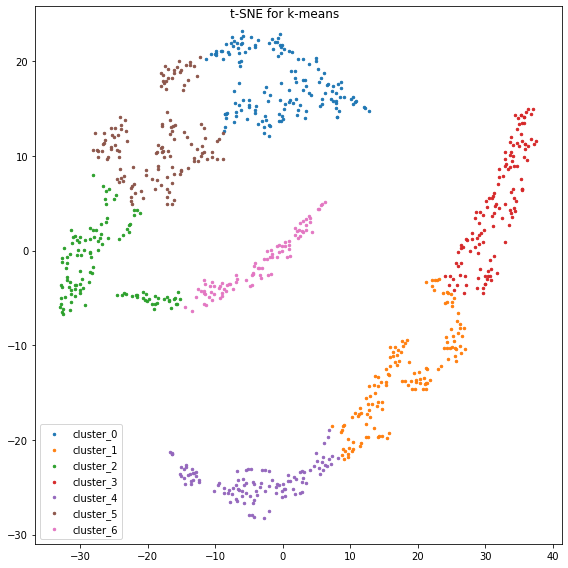

In [303]:
fig = plt.figure(figsize=(8, 8))
for cluster in range(7):
    mask = (k_means_prediction == cluster)
    plt.scatter(embedding[mask, 0], embedding[mask, 1], label=f'cluster_{cluster}', s=6)
plt.suptitle('t-SNE for k-means')
plt.legend()
fig.tight_layout()

By control sirna visualization:

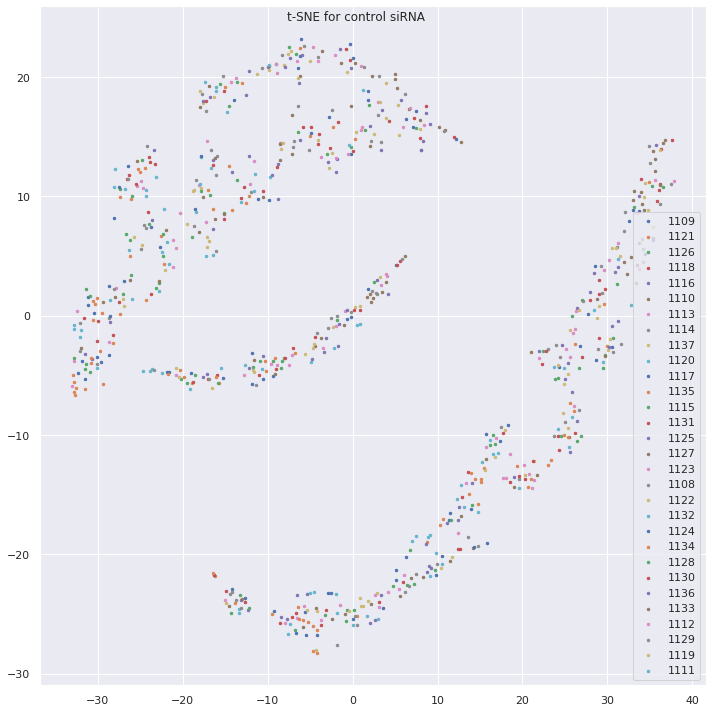

In [23]:
fig = plt.figure(figsize=(10, 10))
for sirna in positive_control_sirna:
    mask = (train_controls.sirna.values == sirna)
    plt.scatter(embedding[mask, 0], embedding[mask, 1], label=sirna, s=6)
plt.legend()
plt.suptitle('t-SNE for control siRNA')
fig.tight_layout()

We see the batch effect phenomenon clearly, the experiments appear clustered and separable. Our goal is to eventually reach a t-SNE plot where the separate experiments are relatively close to each other and the positive sirna's are easily distinguishable across experiments.

Let's now shift our focus to PCA, a decomposition better suited to predict on.

In [260]:
pca = PCA()

In [261]:
pca_transforms = pca.fit_transform(statistics)

In [262]:
pca_transforms.shape

(872, 18)

In [267]:
print('{:.2%} of variance explained by first to PCs'.format(sum(pca.explained_variance_ratio_[:2])))

98.04% of variance explained by first to PCs


In [268]:
pca.components_[0]

array([0.33027117, 0.1425382 , 0.27674893, 0.33405125, 0.42327989,
       0.24806474, 0.25769339, 0.15262906, 0.24415817, 0.31959324,
       0.36193118, 0.23030878, 0.0532549 , 0.00329264, 0.01946863,
       0.02228086, 0.04832794, 0.01314412])

In [269]:
pca.components_[1]

array([-0.05800464, -0.26161966,  0.08787416, -0.47320832,  0.43688333,
       -0.12445977,  0.23841277, -0.24750199,  0.08015631, -0.41929876,
        0.41258228, -0.1015614 , -0.02044749, -0.02240313,  0.01787237,
       -0.05971385,  0.06678136, -0.00687058])

In [270]:
svc = SVC(kernel='linear')

In [271]:
svc.fit(pca_transforms[:, :2], _experiments)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [272]:
svc_predictions = svc.predict(pca_transforms[:, :2])

In [274]:
print(confusion_matrix(_experiments, svc_predictions))

[[ 49  66   8   3   0   0   0]
 [  9 102  12   1   0   0   2]
 [  0   5  29  21  24   3  42]
 [  0   0   3  13  74   0  34]
 [  0   0   1   1 107   2  13]
 [  0   2   7  10  59   6  40]
 [  0   0   0   2  86   2  34]]


In [275]:
print(classification_report(_experiments, svc_predictions))

              precision    recall  f1-score   support

           0       0.84      0.39      0.53       126
           1       0.58      0.81      0.68       126
           2       0.48      0.23      0.32       124
           3       0.25      0.10      0.15       124
           4       0.31      0.86      0.45       124
           5       0.46      0.05      0.09       124
           6       0.21      0.27      0.24       124

    accuracy                           0.39       872
   macro avg       0.45      0.39      0.35       872
weighted avg       0.45      0.39      0.35       872



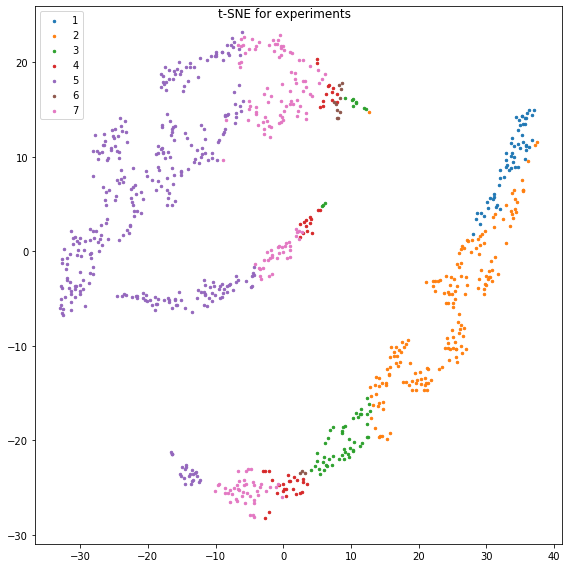

In [305]:
fig = plt.figure(figsize=(8, 8))
for i in range(7):
    mask = (svc_predictions == i)
    plt.scatter(embedding[mask, 0], embedding[mask, 1], label=i+1, s=6)    
    
plt.suptitle('t-SNE for experiments')
plt.legend()
fig.tight_layout()